# DS-NYC-45 | Unit Project 3: Basic Machine Learning Modeling

In this project, you will perform a logistic regression on the admissions data we've been working with in Unit Projects 1 and 2.

In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.notebook_repr_html', True)

import statsmodels.api as sm

from sklearn import linear_model

In [2]:
df = pd.read_csv(os.path.join('dataset/ucla-admissions.csv'))
df.dropna(inplace = True)

df

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0
...,...,...,...,...
395,0,620.0,4.00,2.0
396,0,560.0,3.04,3.0
397,0,460.0,2.63,2.0
398,0,700.0,3.65,2.0


## Part A.  Frequency Table

> ### Question 1.  Create a frequency table for `prestige` and whether or not an applicant was admitted.

In [3]:
# frequency table
prestige_freq=pd.crosstab(index=df.admit,columns=df.prestige)
prestige_freq

prestige,1.0,2.0,3.0,4.0
admit,,,,
0,28,95,93,55
1,33,53,28,12


## Part B.  Variable Transformations

> ### Question 2.  Create a one-hot encoding for `prestige`.

In [4]:
one_hot = pd.get_dummies(df.prestige, drop_first=True,prefix='prestige')
one_hot.head()

,prestige_2.0,prestige_3.0,prestige_4.0
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


> ### Question 3.  How many of these binary variables do we need for modeling?

Answer: We need n-1 binary variables for modeling (in this case three variables for undergrad school tier). We do not need all of them since we can drop one and just indicate that all others are equal to False in the instances when the dropped variable was equal to True. 

> ### Question 4.  Why are we doing this?

Answer: Encoding of categorical variables is necessary when using linear models such as linear and logistic regression. Such models require the predictors to be in some sort of numeric encoding but numerical categories have no meaning (i.e. relevant coefficients cannot be calculated for each of the predictors). Thus, dummy variables need to be introduced to be able to calculate the meaningful coefficients.

> ### Question 5.  Add all these binary variables in the dataset and remove the now redundant `prestige` feature.

In [5]:
df = df.drop('prestige', axis=1)
df = df.join(one_hot)
df.head()

,admit,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0
0,0,380.0,3.61,0.0,1.0,0.0
1,1,660.0,3.67,0.0,1.0,0.0
2,1,800.0,4.00,0.0,0.0,0.0
3,1,640.0,3.19,0.0,0.0,1.0
4,0,520.0,2.93,0.0,0.0,1.0


## Part C.  Hand calculating odds ratios

Let's develop our intuition about expected outcomes by hand calculating odds ratios.

> ### Question 6.  Create a frequency table for `prestige = 1` and whether or not an applicant was admitted.

In [6]:
pd.DataFrame(prestige_freq[[1.0]])

prestige,1.0
admit,
0,28
1,33


> ### Question 7.  Use the frequency table above to calculate the odds of being admitted to graduate school for applicants that attended the most prestigious undergraduate schools.

In [7]:
pr1_odds=33.0/28
print pr1_odds

1.17857142857


> ### Question 8.  Now calculate the odds of admission for undergraduates who did not attend a #1 ranked college.

In [8]:
# aggregate applicant admission records for those who attended undegrad schools tiers 2 to 4
non_prestige=prestige_freq.drop(1.0,axis=1)
non_prestige=non_prestige.sum(axis=1)
non_prestige

admit
0    243
1     93
dtype: int64

In [9]:
non_pr_odds=93.0/243
print non_pr_odds

0.382716049383


> ### Question 9.  Finally, what's the odds ratio?

In [10]:
# Odds ratio of presige_1 and presige_2-4
print 1.17857142857/0.382716049383

3.07949308755


> ### Question 10.  Write this finding in a sentenance.

Answer: The odds to be admitted to UCLA for the applicants who attended the most prestigious undergrad schools are 3X higher than for those who did not.

> ### Question 11.  Use the frequency table above to calculate the odds of being admitted to graduate school for applicants that attended the least prestigious undergraduate schools.  Then calculate their odds ratio of being admitted to UCLA.  Finally, write this finding in a sentence.

In [11]:
prestige_freq

prestige,1.0,2.0,3.0,4.0
admit,,,,
0,28,95,93,55
1,33,53,28,12


In [12]:
pr4_table=pd.DataFrame({'probability':12.0/(12+55)},index=['prestige_4'])
pr4_table['odds']=pr4_table.probability/(1 - pr4_table.probability)
pr4_table['odds_ratio']=(12.0/55)/((28.0+53+33)/(93.0+95+28))
pr4_table

,probability,odds,odds_ratio
prestige_4,0.179104,0.218182,0.413397


Answer: The odds for applicants who attended the least prestigious undergrad schools are 12 to 55, their odds of getting admitted to UCLA are about 59% lower than the rest of the applicants.

## Part C. Analysis using `statsmodels`

> ### Question 12.  Fit a logistic regression model prediting admission into UCLA using `gre`, `gpa`, and the prestige of the undergraduate schools.  Use the highest prestige undergraduate schools as your reference point.

In [13]:
df['intercept']=1.0

In [14]:
X = df.columns[1:]
model = sm.Logit(df.admit,df[X])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


> ### Question 13.  Print the model's summary results.

In [15]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Thu, 02 Feb 2017   Pseudo R-squ.:                 0.08166
Time:                        16:33:09   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
gre              0.0022      0.001      2.028      0.043      7.44e-05     0.004
gpa              0.7793      0.333      2.344      0.019         0.128     1.431
prestige_2.0    -0.6801      0.317     -2.14

> ### Question 14.  What are the odds ratios of the different features and their 95% confidence intervals?

In [16]:
conf_int = result.conf_int()
ORs = pd.DataFrame({'OR':np.exp(result.params),'2.5%':np.exp(conf_int[0]),'97.5%':np.exp(conf_int[1])})
ORs

,2.5%,97.5%,OR
gre,1.000074,1.004372,1.002221
gpa,1.136120,4.183113,2.180027
prestige_2.0,0.272168,0.942767,0.506548
prestige_3.0,0.133377,0.515419,0.262192
prestige_4.0,0.093329,0.479411,0.211525
intercept,0.002207,0.194440,0.020716


> ### Question 15.  Interpret the odds ratio for `prestige = 2`.

Answer:  Holding the rest of the features at a fixed value, the odds of being admitted to UCLA for applicants who attended undergrad schools with prestige score = 2 over the odds of those who attended schools with prestige scores of 1 are 50% lower. 

> ### Question 16.  Interpret the odds ratio of `gpa`.

Answer: Holding GRE and prestige scores at a fixed value, there is a 118% increase in the odds of being admitted to UCLA for a one-point increase in GPA score.

> ### Question 17.  Assuming a student with a GRE of 800 and a GPA of 4.  What is his/her probability of admission  if he/she come from a tier-1, tier-2, tier-3, or tier-4 undergraduate school?

In [17]:
# create a DataFrame for students with GRE of 800, GPA of 4 who went to scools of tier 1 through 4
student = pd.DataFrame({'gre': 800,'gpa': 4.0,'prestige_1.0':[1,0,0,0],'prestige_2.0':[0,1,0,0],'prestige_3.0':[0,0,1,0],
                        'prestige_4.0':[0,0,0,1],'intercept':1.0})

In [18]:
# calculate probability of each of the students being admitted to UCLA grad 
student['admit_prob'] = result.predict(student[X])
student

,gpa,gre,intercept,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0,admit_prob
0,4.0,800,1.0,1,0,0,0,0.734040
1,4.0,800,1.0,0,1,0,0,0.582995
2,4.0,800,1.0,0,0,1,0,0.419833
3,4.0,800,1.0,0,0,0,1,0.368608


## Part D. Moving the model from `statsmodels` to `sklearn`

> ### Question 18.  Let's assume we are satisfied with our model.  Remodel it (same features) using `sklearn`.  When creating the logistic regression model with `LogisticRegression(C = 10 ** 2)`.

In [19]:
df.columns

Index([u'admit', u'gre', u'gpa', u'prestige_2.0', u'prestige_3.0',
       u'prestige_4.0', u'intercept'],
      dtype='object')

In [20]:
feature_cols = ['gre', 'gpa','prestige_2.0','prestige_3.0','prestige_4.0']
predictors = df[feature_cols]
admit = df['admit']

In [21]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C = 10 ** 2)

> ### Question 19.  What are the odds ratios for the different variables and how do they compare with the odds ratios calculated with `statsmodels`?

In [22]:
result2 = logreg.fit(predictors, admit)
zip(feature_cols, logreg.coef_[0])

[('gre', 0.0021582154270036167),
 ('gpa', 0.67315495499507594),
 ('prestige_2.0', -0.62882238681230074),
 ('prestige_3.0', -1.2522274512261706),
 ('prestige_4.0', -1.5687921214919247)]

In [23]:
# sklearn odds ratios withou using Standard scaler
OR_skl=pd.DataFrame({'OR_sklearn':np.exp(logreg.coef_[0])},index=feature_cols)
OR_skl

,OR_sklearn
gre,1.002161
gpa,1.960413
prestige_2.0,0.533219
prestige_3.0,0.285867
prestige_4.0,0.208297


In [24]:
OR_sm = pd.DataFrame(ORs.OR)
OR_sm.columns=['OR_sm']

In [25]:
# joining two tables here and calculate the difference between statsmodels and sklearn odds ratios
compare_ORs = OR_sm.join(OR_skl)
compare_ORs['OR_dif']=OR_sm.OR_sm/OR_skl.OR_sklearn
compare_ORs

,OR_sm,OR_sklearn,OR_dif
gre,1.002221,1.002161,1.000060
gpa,2.180027,1.960413,1.112025
prestige_2.0,0.506548,0.533219,0.949980
prestige_3.0,0.262192,0.285867,0.917182
prestige_4.0,0.211525,0.208297,1.015501
intercept,0.020716,NaN,NaN


Answer: The odds ratio for GPA is the highest among all features. GRE also has high odds ratio compared to the other features, meaning that a one-point change in GRE could increase the chances of a student being accepted by 29% (sklearn odds ratio). 

Between statsmodels and sklearn, the odds ratios are pretty similar with ~5-11% discrepancy.

> ### Question 20.  Again assuming a student with a GRE of 800 and a GPA of 4.  What is his/her probability of admission  if he/she come from a tier-1, tier-2, tier-3, or tier-4 undergraduate school?

In [26]:
student_skl = pd.DataFrame({'gre': 800.0,'gpa': 4.00,'prestige_2.0':[0.0,1.0,0.0,0.0],'prestige_3.0':[0.0,0.0,1.0,0.0],
                        'prestige_4.0':[0.0,0.0,0.0,1.0]})
student_skl

,gpa,gre,prestige_2.0,prestige_3.0,prestige_4.0
0,4.0,800.0,0.0,0.0,0.0
1,4.0,800.0,1.0,0.0,0.0
2,4.0,800.0,0.0,1.0,0.0
3,4.0,800.0,0.0,0.0,1.0


In [27]:
admit_proba = result2.predict_proba(student_skl[feature_cols])
probabilities = pd.DataFrame({'prestige':[1,2,3,4],'admit_proba':admit_proba[:,1]})
probabilities

,admit_proba,prestige
0,0.711854,1
1,0.568463,2
2,0.413911,3
3,0.339755,4


# DS-NYC-45 | Unit Project 4: Notebook with Executive Summary

In this project, you will summarize and present your analysis from Unit Projects 1-3.

## Introduction

Using a dataset of 400 applicants, determine a probability of an applicant of being admitted to UCLA graduate school based on his/her GPA, GRE scores and the prestige on the undergraduate school an applicant attended. 

## Dataset

The dataset includes 400 records where each record represents an applicant GRE, GPA scores, prestige of the undergrad school attended and an outcome variable: whether an applicant was admitted to UCLA grad program.

The data types include continuous (GRE,GPA) and categorical (admit, prestige) variables.

The data set had rows that contained NULLs. Those rows were dropped. 

## Demo: Data by Admission Status

| Admitted        | AVG GRE           | AVG GPA  | PCT Prestige 1 | PCT Prestige 2 | PCT Prestige 3 | PCT Prestige 4 |
| :-------------: |:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|
| 0 | 574 | 3.35 | 46% | 64% | 77% | 82% |
| 1 | 619 |   3.49 | 54% | 36% | 23% | 18% |

 ##   Methods

Odds ratios were produced using statmodels. Based on the odds ratios probability was calculated to determine how likely a student is to be admitted to UCLA grad program.

Logistic regression from sklearn was used to solve this classification problem and predict the admission outcome.

##  Visuals

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

In [29]:
gre_scores = np.linspace(df.gre.min(), df.gre.max(),25)
gpa_scores = np.linspace(df.gpa.min(), df.gpa.max(),25)

In [30]:
from sklearn.utils.extmath import cartesian

In [31]:
new_data = pd.DataFrame(cartesian([gre_scores,gpa_scores, [1,2,3,4],[1.]]))
new_data.columns = ['gre','gpa','prestige','intercept']

In [32]:
dummies = pd.get_dummies(new_data.prestige, drop_first=True,prefix='prestige')

In [33]:
new_data = new_data.join(dummies)

In [34]:
new_data['admit_pred']=result.predict(new_data[X])

In [35]:
new_data.head()

,gre,gpa,prestige,intercept,prestige_2.0,prestige_3.0,prestige_4.0,admit_pred
0,220.0,2.2600,1.0,1.0,0.0,0.0,0.0,0.164173
1,220.0,2.2600,2.0,1.0,1.0,0.0,0.0,0.090492
2,220.0,2.2600,3.0,1.0,0.0,1.0,0.0,0.048977
3,220.0,2.2600,4.0,1.0,0.0,0.0,1.0,0.039890
4,220.0,2.3325,1.0,1.0,0.0,0.0,0.0,0.172074


In [36]:
# plot AVG proba for GRE scores and all prestige variatoins
chart_gre = new_data.groupby(['prestige','gre'])[['admit_pred']].mean()

In [37]:
chart_gre.head()

admit_pred
prestige gre                   
1.0      220.000000    0.286118
         244.166667    0.296826
         268.333333    0.307754
         292.500000    0.318895
         316.666667    0.330238

In [38]:
df1 = chart_gre.unstack(level = 0)

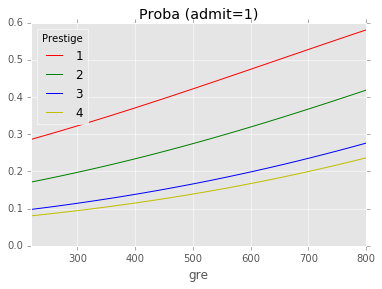

In [39]:
plt.figure()
with pd.plot_params.use('x_compat', True):
    pr1 = df1['admit_pred',1.0].plot(color='r',label='1')
    pr2 = df1['admit_pred',2.0].plot(color='g', label='2')
    pr3 = df1['admit_pred',3.0].plot(color='b', label='3')
    pr4 = df1['admit_pred',4.0].plot(color='y', label='4')
    plt.legend(['1', '2', '3', '4'], loc='upper left', title='Prestige')
    plt.title("Proba (admit=1)")

In [40]:
# plot AVG proba for GPA scores and all prestige variatoins
chart_gpa = new_data.groupby(['prestige','gpa'])[['admit_pred']].mean()

In [41]:
df2 = chart_gpa.unstack(level = 0)

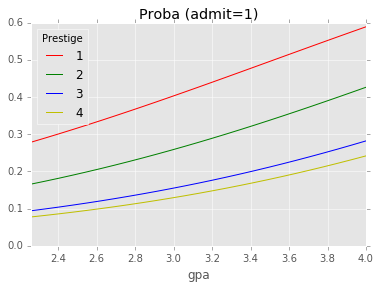

In [42]:
plt.figure()
with pd.plot_params.use('x_compat', True):
    pr1 = df2['admit_pred',1.0].plot(color='r',label='1')
    pr2 = df2['admit_pred',2.0].plot(color='g', label='2')
    pr3 = df2['admit_pred',3.0].plot(color='b', label='3')
    pr4 = df2['admit_pred',4.0].plot(color='y', label='4')
    plt.legend(['1', '2', '3', '4'], loc='upper left', title='Prestige')
    plt.title("Proba (admit=1)")

##  Results

In [43]:
df1['admit_pred','dif 1 and 2'] = df1['admit_pred',1.0] - df1['admit_pred',2.0]
df1['admit_pred','dif 1 and 4'] = df1['admit_pred',1.0] - df1['admit_pred',4.0]
print "Average difference in admission probability between tier 1 and 2 is %f" %(df1['admit_pred','dif 1 and 2'].mean())
print "Average difference in admission probability between tier 1 and 4 is %f" %(df1['admit_pred','dif 1 and 4'].mean())

Average difference in admission probability between tier 1 and 2 is 0.144522
Average difference in admission probability between tier 1 and 4 is 0.281456


Given that GPA and GRE are fixed values for students who attended undergrad schools with prestige tiers 1 through 4, those, who attended the most prestigious school are 45% more likely to be admitted to UCLA grad school compared to those who attended tier 2 school and 181% higher compared to those who attended tier 4 school.

GPA is an important predictor of student admission success, as an increase of 1 point in GPA given that all other predictor values remain the same, increases the odds of being admitted by 118%.

A hundred points increase in GRE increases odds of an applicant being admitted by 20%.

## Discussion

Other models such as Decision Trees and Random Forests can be used to potentially reach a higher level of accuracy.